In [84]:
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from scipy.misc import comb
from collections import defaultdict

## Clean up

In [85]:
# trial_faces_dir = '/home/levan/Datasets/frovaltine_store/dstatrial/face'
trial_faces_dir = '/home/levan/Datasets/frovaltine_store/dstatrial/face_clean'
imgs = []
img_names = []
id2imgs = defaultdict(list)
for ip in Path(trial_faces_dir).iterdir():
    if ip.is_file():
        enrol=False
        uid = int(ip.stem.split('_')[1])
        if 'enrollment' in ip.stem:
            enrol=True
        img = cv2.imread(str(ip))
        id2imgs[uid].append((img, enrol))

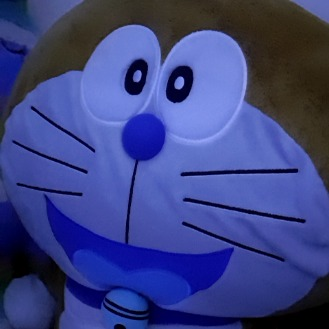

In [86]:
Image.fromarray(list(id2imgs.values())[1][0][0])

In [25]:
from dlib_fd.mobnet_dlib import Mobnet_FD as FaceDet

In [26]:
faceDet = FaceDet(gpu_usage=0.4, max_n = 3, fd_threshold=0.15)

Initalising Mobilenet SSD FD at 0.4 gpu usage..
FACE DETECTION: Mobilenet SSD FD object initalised


In [87]:
no_face = []
id2imgs_clean = defaultdict(list)
for uid, id_imgs in tqdm(id2imgs.items()):
    for i, imgtup in enumerate(id_imgs):
        img, _ = imgtup
#         cv2img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        bbs, aligned_faces = faceDet.detect_align_faces(img, imgDim=112)
        if len(bbs) <= 0:
            no_face.append((img, uid, i))
        else:
#             faces.append(aligned_faces[0])
            id2imgs_clean[uid].append(aligned_faces[0])

100%|██████████| 160/160 [00:10<00:00, 14.94it/s]


In [88]:
len(no_face)
no_face_dir = '/home/levan/Datasets/frovaltine_store/dstatrial/no_faces_0.15'
Path(no_face_dir).mkdir()
for img, uid, i in no_face:
    p = Path(no_face_dir) / '{}_{}.png'.format(uid, i) 
    cv2.imwrite(str(p), img)

In [89]:
num_imgs_each = [len(l) for l in id2imgs.values()]
total_imgs = sum(num_imgs_each)
num_imgs_each_cleaned = [len(l) for l in id2imgs_clean.values()]
total_faces_cleaned = sum(num_imgs_each_cleaned)
print('Before clean: {}, After clean: {}'.format(total_imgs, total_faces_cleaned))

Before clean: 701, After clean: 683


In [90]:
total_uid = len(id2imgs_clean.keys())
num_imgs_each = [len(l) for l in id2imgs_clean.values()]
total_faces = sum(num_imgs_each)

In [91]:
num_positive_matches = int(sum([comb(len(l),2) for l in id2imgs_clean.values()]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """Entry point for launching an IPython kernel.


In [92]:
print('Total uid: {}\nTotal legal faces: {}\nTotal positive matches: {}'.format(total_uid, total_faces, num_positive_matches))

Total uid: 159
Total legal faces: 683
Total positive matches: 1309


## Generate Pairs

In [93]:
import itertools
# x = [1,2,3,4]
# list(itertools.combinations(x, 2))
# [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

### Matching Pairs

In [98]:
processed_faces_dir = '/home/levan/Datasets/frovaltine_store/dstatrial/processed_faces'

matching_pairs = []
sorted_uid = sorted(id2imgs_clean.keys()) 
for uid in sorted_uid:    
    imgs_list = id2imgs_clean[uid]
    print('UID', uid)
    print('len img list', len(imgs_list))
    for pair in itertools.combinations(range(len(imgs_list)),2):
        pair_str = ('{}_{}'.format(uid, pair[0]), '{}_{}'.format(uid,pair[1]))
        print(pair_str)
        matching_pairs.append(pair_str)
    
    for i, img in enumerate(imgs_list):
        new_path = Path(processed_faces_dir) / '{}_{}.png'.format(uid, i)
        cv2.imwrite(str(new_path), img)
        

UID 2
len img list 3
('2_0', '2_1')
('2_0', '2_2')
('2_1', '2_2')
UID 4
len img list 5
('4_0', '4_1')
('4_0', '4_2')
('4_0', '4_3')
('4_0', '4_4')
('4_1', '4_2')
('4_1', '4_3')
('4_1', '4_4')
('4_2', '4_3')
('4_2', '4_4')
('4_3', '4_4')
UID 6
len img list 4
('6_0', '6_1')
('6_0', '6_2')
('6_0', '6_3')
('6_1', '6_2')
('6_1', '6_3')
('6_2', '6_3')
UID 7
len img list 6
('7_0', '7_1')
('7_0', '7_2')
('7_0', '7_3')
('7_0', '7_4')
('7_0', '7_5')
('7_1', '7_2')
('7_1', '7_3')
('7_1', '7_4')
('7_1', '7_5')
('7_2', '7_3')
('7_2', '7_4')
('7_2', '7_5')
('7_3', '7_4')
('7_3', '7_5')
('7_4', '7_5')
UID 9
len img list 6
('9_0', '9_1')
('9_0', '9_2')
('9_0', '9_3')
('9_0', '9_4')
('9_0', '9_5')
('9_1', '9_2')
('9_1', '9_3')
('9_1', '9_4')
('9_1', '9_5')
('9_2', '9_3')
('9_2', '9_4')
('9_2', '9_5')
('9_3', '9_4')
('9_3', '9_5')
('9_4', '9_5')
UID 10
len img list 4
('10_0', '10_1')
('10_0', '10_2')
('10_0', '10_3')
('10_1', '10_2')
('10_1', '10_3')
('10_2', '10_3')
UID 12
len img list 4
('12_0', '12_1

### Diff Pairs

In [99]:
target_num_pairs = len(matching_pairs)

In [109]:
from random import sample
diff_pairs = []
for _ in range(target_num_pairs):
    tup = []
    for uid in sample(sorted_uid,2):
        idx = sample(range(len(id2imgs_clean[uid])),1)[0]
        tup.append('{}_{}'.format(uid, idx))
    print(tup)
    diff_pairs.append(tuple(tup))
len(diff_pairs)

['74_4', '37_5']
['191_3', '45_1']
['230_0', '138_1']
['101_2', '213_0']
['90_1', '45_2']
['164_0', '127_3']
['169_2', '41_1']
['85_4', '182_0']
['40_2', '239_3']
['219_0', '233_5']
['171_0', '29_2']
['111_1', '154_0']
['167_1', '138_3']
['87_5', '39_0']
['30_1', '40_2']
['137_4', '183_0']
['41_2', '83_1']
['127_4', '23_1']
['167_3', '238_3']
['43_2', '101_1']
['38_1', '210_3']
['35_1', '193_3']
['94_0', '164_0']
['66_0', '216_1']
['23_4', '66_4']
['45_0', '227_5']
['57_3', '245_2']
['54_4', '82_2']
['136_0', '164_1']
['87_1', '160_1']
['204_0', '33_4']
['228_3', '217_3']
['31_4', '152_0']
['53_1', '175_1']
['169_0', '215_4']
['2_1', '242_1']
['191_1', '202_2']
['155_0', '111_1']
['85_2', '107_1']
['79_1', '33_3']
['149_2', '160_1']
['126_2', '139_0']
['79_1', '105_2']
['10_1', '217_0']
['243_3', '58_0']
['164_0', '59_5']
['128_1', '156_0']
['79_1', '67_4']
['137_4', '107_4']
['159_0', '107_1']
['37_5', '241_4']
['75_2', '250_1']
['138_2', '226_1']
['219_3', '237_0']
['127_4', '255_2']

1309

In [111]:
with open('/home/levan/Datasets/frovaltine_store/dstatrial/pairs.txt','w') as f:
    for pair in matching_pairs:
        f.write('{} {}\n'.format(*pair))
    for pair in diff_pairs:
        f.write('{} {}\n'.format(*pair))

## Embedding

In [115]:
from arcface_infer import Arcface as FaceReg
faceReg = FaceReg(model_path=None, use_gpu=True, tta=False)

ir_se_50 FR model (arcface) generated
warming up..
warmed up! 0.067s


In [118]:
faceid2emb = {}
embs_dir='/home/levan/Datasets/frovaltine_store/dstatrial/embs'
for uid in tqdm(sorted_uid):
    for i, face in enumerate(id2imgs_clean[uid]):
        emb = faceReg.embed([face])
        faceid = '{}_{}'.format(uid, i)
        emb_path = Path(embs_dir) / '{}.npy'.format(faceid) 
        np.save(emb_path, emb)
        faceid2emb[faceid] = emb

100%|██████████| 159/159 [00:08<00:00, 18.78it/s]


## and finally, EVAL

### TPR
TP / (TP + FN)
Out of all the Positives, how many we correctly let in

### FPR
FP / (FP + TN)
Out of all the Negatives, how many we let in

In [179]:
thresholds = np.arange(0.0, 2.0, 0.01)
plot_thresh = []
tprs = []
fprs = []
for i, thresh in enumerate(thresholds):
    tp,fn,fp,tn = 0,0,0,0
    dists = []
    for pair in matching_pairs:
        emb1 = faceid2emb[pair[0]]    
        emb2 = faceid2emb[pair[1]]
        dist = np.linalg.norm(emb1-emb2)
        if dist < thresh:
            tp += 1
        else:
            fn += 1
        dists.append(dist)
    for pair in diff_pairs:
        emb1 = faceid2emb[pair[0]]    
        emb2 = faceid2emb[pair[1]]
        dist = np.linalg.norm(emb1-emb2)
        if dist < thresh:
            fp += 1
        else:
            tn += 1
        dists.append(dist)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    print('Thresh: {}, TPR: {}, FPR: {}'.format(thresh, tpr, fpr))
    tprs.append(tpr)
    fprs.append(fpr)
    if i%1==0:
        plot_thresh.append((thresh, fpr))

Thresh: 0.0, TPR: 0.0, FPR: 0.0
Thresh: 0.01, TPR: 0.0, FPR: 0.0
Thresh: 0.02, TPR: 0.0, FPR: 0.0
Thresh: 0.03, TPR: 0.0, FPR: 0.0
Thresh: 0.04, TPR: 0.0, FPR: 0.0
Thresh: 0.05, TPR: 0.0, FPR: 0.0
Thresh: 0.06, TPR: 0.0, FPR: 0.0
Thresh: 0.07, TPR: 0.0, FPR: 0.0
Thresh: 0.08, TPR: 0.0, FPR: 0.0
Thresh: 0.09, TPR: 0.0, FPR: 0.0
Thresh: 0.1, TPR: 0.0, FPR: 0.0
Thresh: 0.11, TPR: 0.0, FPR: 0.0
Thresh: 0.12, TPR: 0.0, FPR: 0.0
Thresh: 0.13, TPR: 0.0, FPR: 0.0
Thresh: 0.14, TPR: 0.0, FPR: 0.0
Thresh: 0.15, TPR: 0.0, FPR: 0.0
Thresh: 0.16, TPR: 0.0, FPR: 0.0
Thresh: 0.17, TPR: 0.0, FPR: 0.0
Thresh: 0.18, TPR: 0.0, FPR: 0.0
Thresh: 0.19, TPR: 0.0, FPR: 0.0
Thresh: 0.2, TPR: 0.0, FPR: 0.0
Thresh: 0.21, TPR: 0.0, FPR: 0.0
Thresh: 0.22, TPR: 0.0, FPR: 0.0
Thresh: 0.23, TPR: 0.0, FPR: 0.0
Thresh: 0.24, TPR: 0.0, FPR: 0.0
Thresh: 0.25, TPR: 0.0, FPR: 0.0
Thresh: 0.26, TPR: 0.0007639419404125286, FPR: 0.0
Thresh: 0.27, TPR: 0.002291825821237586, FPR: 0.0
Thresh: 0.28, TPR: 0.002291825821237586, FPR

In [150]:
max(dists), min(dists), np.mean(dist), np.median(dist)

(1.3549171138661407,
 0.25304813233650714,
 0.9154924539087732,
 0.9154924539087732)

In [169]:
plot_thresh

[(0.0, 0.0),
 (0.1, 0.0),
 (0.2, 0.0),
 (0.3, 0.0),
 (0.4, 0.0),
 (0.5, 0.0),
 (0.6, 0.0),
 (0.7000000000000001, 0.0007639419404125286),
 (0.8, 0.025974025974025976),
 (0.9, 0.1917494270435447),
 (1.0, 0.5699006875477464),
 (1.1, 0.8418640183346066),
 (1.2, 0.9572192513368984),
 (1.3, 0.9961802902979373),
 (1.4000000000000001, 1.0),
 (1.5, 1.0),
 (1.6, 1.0),
 (1.7, 1.0),
 (1.8, 1.0),
 (1.9000000000000001, 1.0)]

In [183]:
chosen_threshes = [0.8, 0.85, 0.9, 1.0]

In [184]:
import plotly.graph_objects as go

In [155]:
def getAUC(fprs, tprs):
    sortedFprs, sortedTprs = zip(*sorted(zip(*(fprs, tprs))))
    sortedFprs = list(sortedFprs)
    sortedTprs = list(sortedTprs)
    if sortedFprs[-1] != 1.0:
        sortedFprs.append(1.0)
        sortedTprs.append(sortedTprs[-1])
    return np.trapz(sortedTprs, sortedFprs)

In [224]:
perfect_AUC = getAUC([0,0,1], [0,1,1])
perfect_AUC

1.0

In [225]:
AUC = getAUC(fprs, tprs)
AUC

0.9226510244350535

In [226]:
fig = go.Figure()


arcface_trace = go.Scatter(x=np.array(fprs),
                           y=np.array(tprs),
                           name='arcface, AUC={:0.3f}'.format(AUC),
                           marker=dict(color='darkorchid')
                          )

# fig.add_trace(go.Scatter(
#     x=[],
#     y=[],
#     text=["AUC={}".format(AUC)],
#     mode="text",
#     textfont = {'family': "Courier New, monospace", 'size': [10], 'color': ["darkorchid"]},
#     showlegend=False
# ))


perfect_trace = go.Scatter(x=np.array([0, 0, 1]),
                           y=np.array([0, 1, 1]),
                           name='Perfect, AUC={:0.3f}'.format(perfect_AUC),
                           mode='lines',
                           marker=dict(
                                color='rgba(0, 0, 0, 0.75)',
                                size=10,
                                line=dict(
                                    color='Black',
                                    width=1
                                )
                            ),
                          )

fig.add_trace(arcface_trace)
fig.add_trace(perfect_trace)

for thresh, fpr in plot_thresh:
    if thresh in chosen_threshes:
        fig.add_shape(
                # Line Vertical
                dict(
                    type="line",
                    x0=fpr,
                    y0=0.0,
                    x1=fpr,
                    y1=1.05,
                    line=dict(
                        color="LightSeaGreen",
                        width=3,
                        dash="dashdot",
                    )
        ))
        
        fig.add_trace(go.Scatter(
            x=[fpr+0.028],
            y=[1-1/1.61803398875],
            text=["t={}".format(thresh)],
            mode="text",
            textfont = {'family': "Courier New, monospace", 'size': [10], 'color': ["LightSeaGreen"]},
            showlegend=False
        ))



fig.update_layout(
    title={'text': "Face Verification Accuracy on Trial Dataset",
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=1000,
    height=600,
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)

fig.show()